In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
df = pd.read_csv('train.csv')

# Daten bereinigen
# zb.:2.0 Turbo → 2.0
df["Engine volume"] = df["Engine volume"].astype(str).str.replace(" Turbo", "", regex=False)
df["Engine volume"] = pd.to_numeric(df["Engine volume"], errors="coerce")

# zb.: 150,000 km → 150000
df["Mileage"] = df["Mileage"].astype(str).str.replace(" km", "").str.replace(",", "")
df["Mileage"] = pd.to_numeric(df["Mileage"], errors="coerce")

df.head()


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [232]:
# Ersetze '-' in numerischen Spalten und konvertiere in float
problematische_spalten = ["Levy", "Cylinders"]

for spalte in problematische_spalten:
    df[spalte] = df[spalte].replace("-", np.nan)
    df[spalte] = pd.to_numeric(df[spalte], errors="coerce")


In [233]:
# Gibt es Null-Werte?
df.isnull().sum()

ID                     0
Price                  0
Levy                5819
Manufacturer           0
Model                  0
Prod. year             0
Category               0
Leather interior       0
Fuel type              0
Engine volume          0
Mileage                0
Cylinders              0
Gear box type          0
Drive wheels           0
Doors                  0
Wheel                  0
Color                  0
Airbags                0
dtype: int64

In [234]:
# Realistische Daten auswählen. Viele Autos haben einen Preis von 0 oder eine Laufleistung von 0.
# Diese Autos sind nicht realistisch und sollten entfernt werden.
df = df[
    (df["Price"] >= 500) & (df["Price"] < 100000) &
    (df["Mileage"] > 100) & (df["Mileage"] < 500000)
]


In [235]:
# Kategorische Merkmale umwandeln (One-Hot-Encoding)
categorical = ["Fuel type", "Gear box type", "Drive wheels", "Category", "Manufacturer"]
df_encoded = pd.get_dummies(df, columns=categorical, drop_first=True)


In [236]:
# Fehlende Werte gezielt behandeln
df_encoded["Levy"] = df_encoded["Levy"].fillna(0)
df_encoded["Cylinders"] = df_encoded["Cylinders"].fillna(df_encoded["Cylinders"].median())

In [237]:
# 🧩 Feature-Auswahl (numerisch + kategorisch)
features = [
    "Mileage", "Prod. year", "Engine volume", "Cylinders", "Airbags", "Levy"
] + [col for col in df_encoded.columns if any(col.startswith(cat) for cat in categorical)]

X = df_encoded[features]
y = df_encoded["Price"]

print("Spalten mit NaN in df_encoded:")
print(df_encoded.isnull().sum().sort_values(ascending=False).head(10))


Spalten mit NaN in df_encoded:
ID                            0
Manufacturer_KIA              0
Manufacturer_MINI             0
Manufacturer_MERCURY          0
Manufacturer_MERCEDES-BENZ    0
Manufacturer_MAZDA            0
Manufacturer_MASERATI         0
Manufacturer_LINCOLN          0
Manufacturer_LEXUS            0
Manufacturer_LAND ROVER       0
dtype: int64


In [ ]:
# Welche Features sind wichtig? und Preis ist die Zielvariable
features = ["Mileage", "Prod. year", "Engine volume", "Cylinders", "Airbags", ]
X = df[features]
y = df["Price"]

In [238]:
# Daten aufteilen
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [239]:
# Modell trainieren (Linear Regression)
from sklearn.linear_model import LinearRegression

modelLR = LinearRegression()
# Modell mit den Trainingsdaten trainieren
modelLR.fit(X_train, y_train)


LinearRegression()

In [240]:
# Modell trainieren (Random Forest)

modelRF = RandomForestRegressor(n_estimators=500, random_state=42)
# Modell mit den Trainingsdaten trainieren
modelRF.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [241]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preisvorhersage mit Testdaten
y_pred = modelLR.predict(X_val)

# Modellbewertung
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"MAE (durchschnittlicher Fehler): {mae:.2f} €")
print(f"RMSE (Wurzel aus mittlerem quadratischen Fehler): {rmse:.2f} €")
print(f"R² (Erklärte Varianz): {r2:.3f}")


MAE (durchschnittlicher Fehler): 8141.49 €
RMSE (Wurzel aus mittlerem quadratischen Fehler): 11494.46 €
R² (Erklärte Varianz): 0.392


In [242]:
# Modellbewertung (Random Forest)
y_pred = modelRF.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.2f} €")
print(f"RMSE: {rmse:.2f} €")
print(f"R²: {r2:.3f}")


MAE: 4014.10 €
RMSE: 7076.09 €
R²: 0.769


In [243]:
# Testdaten laden & bereinigen
df_test = pd.read_csv("test.csv")

df_test["Engine volume"] = df_test["Engine volume"].astype(str).str.replace(" Turbo", "", regex=False)
df_test["Engine volume"] = pd.to_numeric(df_test["Engine volume"], errors="coerce")

df_test["Mileage"] = df_test["Mileage"].astype(str).str.replace(" km", "").str.replace(",", "")
df_test["Mileage"] = pd.to_numeric(df_test["Mileage"], errors="coerce")


In [245]:
# 1️⃣ test.csv vorbereiten: gleiche Preprocessing-Schritte wie beim Training
df_test["Mileage"] = df_test["Mileage"].astype(str).str.replace(" km", "").str.replace(",", "")
df_test["Mileage"] = pd.to_numeric(df_test["Mileage"], errors="coerce")

df_test["Engine volume"] = df_test["Engine volume"].astype(str).str.replace(" Turbo", "", regex=False)
df_test["Engine volume"] = pd.to_numeric(df_test["Engine volume"], errors="coerce")

df_test["Levy"] = df_test["Levy"].replace("-", np.nan)
df_test["Levy"] = pd.to_numeric(df_test["Levy"], errors="coerce")
df_test["Levy"] = df_test["Levy"].fillna(0)

df_test["Cylinders"] = pd.to_numeric(df_test["Cylinders"], errors="coerce")
df_test["Cylinders"] = df_test["Cylinders"].fillna(df_test["Cylinders"].median())

df_test["Airbags"] = pd.to_numeric(df_test["Airbags"], errors="coerce")

# 2️⃣ get_dummies wie bei train.csv
df_test_encoded = pd.get_dummies(df_test, columns=categorical, drop_first=True)

# 3️⃣ Fehlende Spalten aus dem Training ergänzen (mit 0 auffüllen)
for col in X.columns:
    if col not in df_test_encoded.columns:
        df_test_encoded[col] = 0

# 4️⃣ Spalten in gleiche Reihenfolge bringen
df_test_encoded = df_test_encoded[X.columns]

# 5️⃣ Vorhersage durchführen
predicted_prices = modelRF.predict(df_test_encoded)

# 🔍 Beispielhafte Ausgabe
print("\nBeispiel-Vorhersagen für test.csv:")
for i, price in enumerate(predicted_prices[:10], 1):
    print(f"Auto {i}: {price:.2f} €")



Beispiel-Vorhersagen für test.csv:
Auto 1: 17450.70 €
Auto 2: 18952.37 €
Auto 3: 7695.61 €
Auto 4: 5803.79 €
Auto 5: 3140.37 €
Auto 6: 32245.66 €
Auto 7: 706.00 €
Auto 8: 13744.75 €
Auto 9: 14114.02 €
Auto 10: 9933.89 €


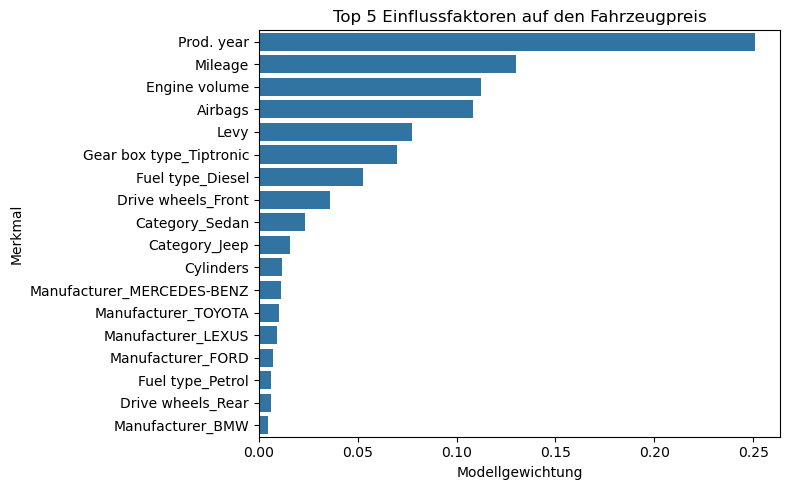

In [257]:
# Wichtigkeit der Merkmale abrufen
importances = modelRF.feature_importances_
feature_names = X.columns

# In DataFrame packen und sortieren
importances_df = pd.DataFrame({
    "Merkmal": feature_names,
    "Wichtigkeit": importances
}).sort_values(by="Wichtigkeit", ascending=False)

# Nur die Top 5 wichtigsten Merkmale auswählen
top5 = importances_df.head(18)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=top5, x="Wichtigkeit", y="Merkmal")
plt.title("Top 5 Einflussfaktoren auf den Fahrzeugpreis")
plt.xlabel("Modellgewichtung")
plt.ylabel("Merkmal")
plt.tight_layout()
plt.show()


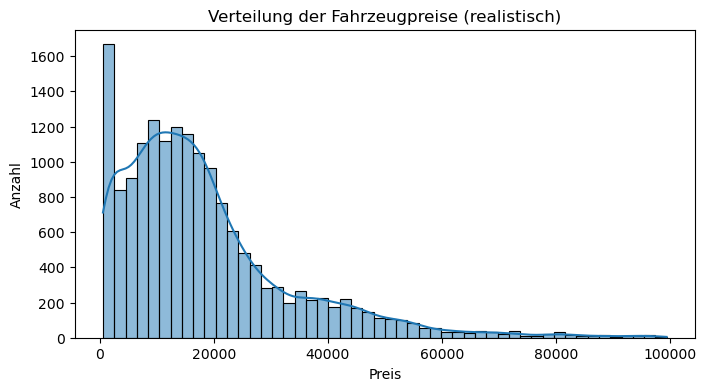

In [249]:
# Korrelationen anzeigen
df_no_extremes = df[df["Price"] >= 500]

plt.figure(figsize=(8, 4))
sns.histplot(df_no_extremes[df_no_extremes["Price"] < 100000]["Price"], kde=True, bins=50)
plt.title("Verteilung der Fahrzeugpreise (realistisch)")
plt.xlabel("Preis")
plt.ylabel("Anzahl")
plt.show()


/tmp/ipykernel_10694/3895181212.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_top, x="Manufacturer", y="Price", estimator='mean', ci=None)


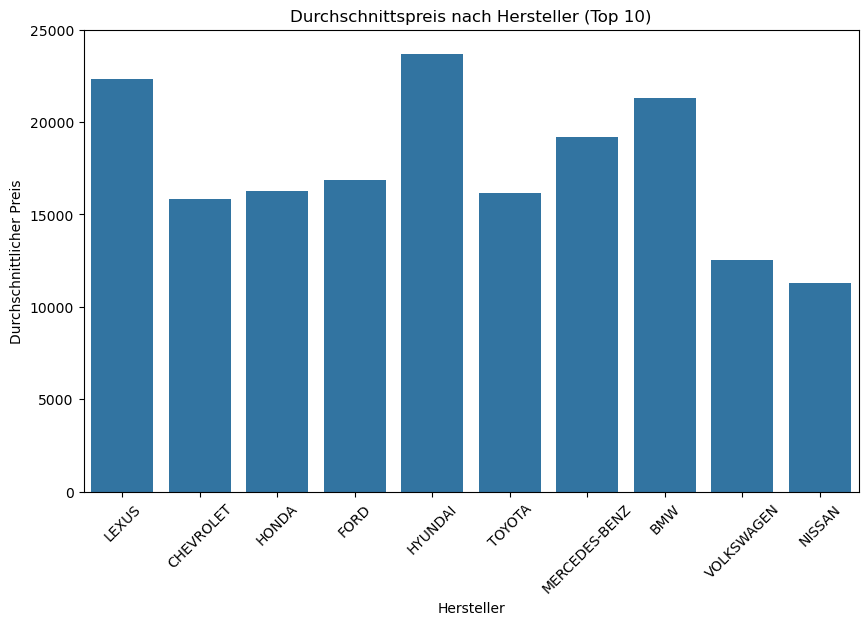

In [250]:
# Nur Top 10 Hersteller anzeigen, Durchschnittspreis
top_manu = df["Manufacturer"].value_counts().head(10).index
df_top = df[df["Manufacturer"].isin(top_manu)]

plt.figure(figsize=(10, 6))
sns.barplot(data=df_top, x="Manufacturer", y="Price", estimator='mean', ci=None)
plt.ylim(0, 25000)
plt.xticks(rotation=45)
plt.title("Durchschnittspreis nach Hersteller (Top 10)")
plt.ylabel("Durchschnittlicher Preis")
plt.xlabel("Hersteller")
plt.show()


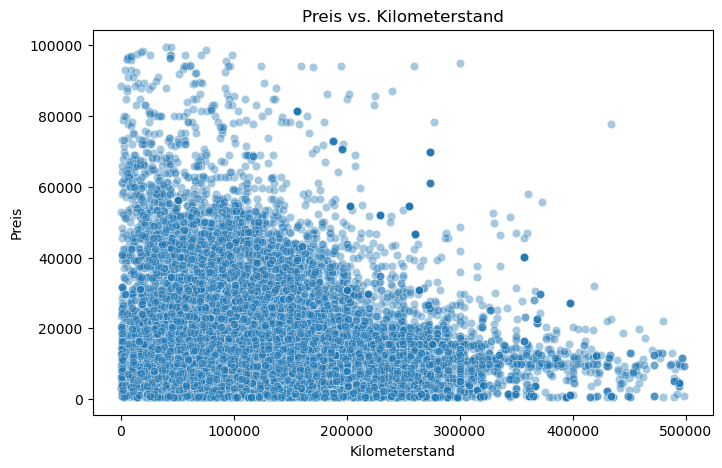

In [251]:
# Scatterplot von Preis vs. Kilometerstand inkl. Ausreißer-Daten
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Mileage", y="Price", alpha=0.4)
plt.title("Preis vs. Kilometerstand")
plt.xlabel("Kilometerstand")
plt.ylabel("Preis")
plt.show()


In [ ]:
# Filter für realistische Preise und Kilometerstände ab 500 bis 200.000 Euro
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = df[
    (df["Price"] >= 500) & (df["Price"] < 200000) &
    (df["Mileage"] < 500000)
]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_filtered, x="Mileage", y="Price", alpha=0.4)
plt.title("Preis vs. Kilometerstand (500–200.000 € & <500.000 km)")
plt.xlabel("Kilometerstand")
plt.ylabel("Preis")
plt.show()


In [ ]:
# Anzahl der Autos mit Preis unter 100 €
anzahl_unter_100 = df[df["Price"] < 100].shape[0]

print(f"Anzahl der Autos mit Preis unter 100 €: {anzahl_unter_100}")

In [ ]:
#Welche Hersteller haben Autos mit Preis unter 100 €?
df[df["Price"] < 100]["Manufacturer"].value_counts()

In [ ]:
# Preisverteilung pro Hersteller (Top 10)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df["Manufacturer"].isin(df["Manufacturer"].value_counts().head(10).index)],
            x="Manufacturer", y="Price")
plt.ylim(0, 40000)
plt.xticks(rotation=45)
plt.title("Preisverteilung pro Hersteller (Top 10)")
plt.ylabel("Preis")
plt.xlabel("Hersteller")
plt.show()


In [ ]:
# Durchschnittspreis nach Kraftstoffart
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Fuel type", y="Price", estimator='mean', ci=None)
plt.title("Durchschnittlicher Preis nach Kraftstoffart")
plt.ylabel("Preis")
plt.xlabel("Kraftstoff")
plt.xticks(rotation=45)
plt.ylim(0, 40000)
plt.show()


In [ ]:
#Durchschnittspreis nach Getriebeart
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x="Gear box type", y="Price", estimator='mean', ci=None)
plt.title("Durchschnittlicher Preis nach Getriebeart")
plt.xlabel("Getriebe")
plt.ylabel("Preis")
plt.ylim(0, 40000)
plt.show()


In [ ]:
# Preisentwicklung nach Baujahr
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="Prod. year", y="Price")
plt.title("Durchschnittlicher Preis nach Baujahr")
plt.xlabel("Baujahr")
plt.ylabel("Preis")
plt.ylim(0, 40000)
plt.show()
